In [4]:
from pynq import MMIO, Overlay
from pynq.lib import AxiGPIO
import time
import numbers

In [7]:
overlay = Overlay('antminerS9SPI.bit')

In [ ]:
overlay?

In [20]:
SPI_regSpace = overlay.ip_dict['axi_quad_spi_0']

In [ ]:
hex(SPI_regSpace['phys_addr']), hex(SPI_regSpace['addr_range'])

In [22]:
IP_BASE_ADDRESS = SPI_regSpace['phys_addr']
IP_ADDRESS_RNGE = SPI_regSpace['addr_range']
AxiQspi = MMIO(IP_BASE_ADDRESS, IP_ADDRESS_RNGE)

In [ ]:
gpio_port5_instance = overlay.ip_dict["plMiner5"]
gpio_port5 = AxiGPIO(gpio_port5_instance).channel1

In [15]:
gpio_port5[0:4].write(0b0001)

In [16]:
gpio_port5[0:4].write(0b0000)

In [8]:
# Xilinx Quad SPI IP Documentation :
# https://docs.amd.com/r/en-US/pg153-axi-quad-spi/XIP-Mode?tocId=2XVwkWB5eiUa4e0XIQSNuA

XSP_DGIER_OFFSET = 0x1C
XSP_IISR_OFFSET = 0x20
XSP_IIER_OFFSET = 0x28
XSP_SRR_OFFSET = 0x40
XSP_CR_OFFSET = 0x60
XSP_SR_OFFSET = 0x64
XSP_DTR_OFFSET = 0x68
XSP_DRR_OFFSET = 0x6C
XSP_SSR_OFFSET = 0x70
XSP_TFO_OFFSET = 0x74
XSP_RFO_OFFSET = 0x78
XSP_REGISTERS = [0x40, 0x60, 0x64, 0x68, 0x6c, 0x70, 0x74, 0x78, 0x1c, 0x20, 0x28]

XSP_SRR_RESET_MASK = 0x0A
XSP_SR_TX_EMPTY_MASK = 0x00000004
XSP_SR_TX_FULL_MASK	= 0x00000008
XSP_CR_TRANS_INHIBIT_MASK = 0x00000100
XSP_CR_LOOPBACK_MASK	= 0x00000001
XSP_CR_ENABLE_MASK	= 0x00000002
XSP_CR_MASTER_MODE_MASK	= 0x00000004
XSP_CR_CLK_POLARITY_MASK = 0x00000008
XSP_CR_CLK_PHASE_MASK	= 0x00000010
XSP_CR_TXFIFO_RESET_MASK = 0x00000020
XSP_CR_RXFIFO_RESET_MASK = 0x00000040
XSP_CR_MANUAL_SS_MASK	= 0x00000080
XSP_CR_TRANS_INHIBIT_MASK = 0x00000100

SLAVE_NO_SELECTION = 0xFFFFFFFF

In [145]:
def cnfg(AxiQspi, clk_phase=0, clk_pol=0):
	#print("Configure device")
	AxiQspi.write(XSP_SRR_OFFSET, XSP_SRR_RESET_MASK)
	AxiQspi.write(XSP_DGIER_OFFSET, 0)
	AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
	ControlReg = AxiQspi.read(XSP_CR_OFFSET)
	ControlReg = ControlReg | XSP_CR_MASTER_MODE_MASK | XSP_CR_MANUAL_SS_MASK | XSP_CR_ENABLE_MASK
	AxiQspi.write(XSP_CR_OFFSET, ControlReg)
	ControlReg = AxiQspi.read(XSP_CR_OFFSET)
	if clk_phase == 1:
		ControlReg = ControlReg | XSP_CR_CLK_PHASE_MASK
	else:
		ControlReg = ControlReg & ~XSP_CR_CLK_PHASE_MASK
	if clk_pol == 1:
		ControlReg = ControlReg | XSP_CR_CLK_POLARITY_MASK
	else:
		ControlReg = ControlReg & ~XSP_CR_CLK_POLARITY_MASK
	AxiQspi.write(XSP_CR_OFFSET, ControlReg)

	return 0

def xfer(packet, AxiQspi):
	#print("TransferData")
	for data in packet:
		AxiQspi.write(XSP_DTR_OFFSET, data)
		AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
		ControlReg = AxiQspi.read(XSP_CR_OFFSET)
		ControlReg = ControlReg & ~XSP_CR_TRANS_INHIBIT_MASK
		AxiQspi.write(XSP_CR_OFFSET, ControlReg)
		
		StatusReg = AxiQspi.read(XSP_SR_OFFSET)
		while (StatusReg & XSP_SR_TX_EMPTY_MASK) == 0:
			StatusReg = AxiQspi.read(XSP_SR_OFFSET)

		#print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(AxiQspi.read(XSP_RFO_OFFSET)))
		ControlReg = AxiQspi.read(XSP_CR_OFFSET)
		ControlReg = ControlReg | XSP_CR_TRANS_INHIBIT_MASK
		AxiQspi.write(XSP_CR_OFFSET, ControlReg)

	AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)

	# print("ReadResponse")
	# resp = list()
	# RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01
	# while RxFifoStatus == 0:
	# 	temp = AxiQspi.read(XSP_RFO_OFFSET)
	# 	print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(temp))
	# 	temp = AxiQspi.read(XSP_DRR_OFFSET)
	# 	print('XSP_DRR_OFFSET  : 0x{0:08x}'.format(temp))    
	# 	resp.append(temp)
	# 	RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01

	# return resp



In [ ]:
#time.sleep(3)
cnfg(AxiQspi)

In [147]:
#time.sleep(3)
xfer([0xFF, 0xF0, 0x00, 0x01], AxiQspi)

<br><br>
# ST7735 SPI TFT LCD Driver Demo
- Source : https://github.com/pimoroni/st7735-python

In [1]:
# Constants for interacting with display registers.

BG_SPI_CS_BACK = 0
BG_SPI_CS_FRONT = 1

ST7735_TFTWIDTH = 130
ST7735_TFTHEIGHT = 130

ST7735_COLS = 130
ST7735_ROWS = 130

ST7735_NOP = 0x00
ST7735_SWRESET = 0x01
ST7735_RDDID = 0x04
ST7735_RDDST = 0x09

ST7735_SLPIN = 0x10
ST7735_SLPOUT = 0x11
ST7735_PTLON = 0x12
ST7735_NORON = 0x13

ST7735_INVOFF = 0x20
ST7735_INVON = 0x21
ST7735_DISPOFF = 0x28
ST7735_DISPON = 0x29

ST7735_CASET = 0x2A
ST7735_RASET = 0x2B
ST7735_RAMWR = 0x2C
ST7735_RAMRD = 0x2E

ST7735_PTLAR = 0x30
ST7735_MADCTL = 0x36
ST7735_COLMOD = 0x3A

ST7735_FRMCTR1 = 0xB1
ST7735_FRMCTR2 = 0xB2
ST7735_FRMCTR3 = 0xB3
ST7735_INVCTR = 0xB4
ST7735_DISSET5 = 0xB6


ST7735_PWCTR1 = 0xC0
ST7735_PWCTR2 = 0xC1
ST7735_PWCTR3 = 0xC2
ST7735_PWCTR4 = 0xC3
ST7735_PWCTR5 = 0xC4
ST7735_VMCTR1 = 0xC5

ST7735_RDID1 = 0xDA
ST7735_RDID2 = 0xDB
ST7735_RDID3 = 0xDC
ST7735_RDID4 = 0xDD

ST7735_GMCTRP1 = 0xE0
ST7735_GMCTRN1 = 0xE1

ST7735_PWCTR6 = 0xFC

# Colours for convenience
ST7735_BLACK = 0x0000  # 0b 00000 000000 00000
ST7735_BLUE = 0x001F  # 0b 00000 000000 11111
ST7735_GREEN = 0x07E0  # 0b 00000 111111 00000
ST7735_RED = 0xF800  # 0b 11111 000000 00000
ST7735_CYAN = 0x07FF  # 0b 00000 111111 11111
ST7735_MAGENTA = 0xF81F  # 0b 11111 000000 11111
ST7735_YELLOW = 0xFFE0  # 0b 11111 111111 00000
ST7735_WHITE = 0xFFFF  # 0b 11111 111111 11111

In [2]:
# utility functions

import numpy as np
# def color565(r, g, b):
#     """Convert red, green, blue components to a 16-bit 565 RGB value. Components
#     should be values 0 to 255.
#     """
#     return ((r & 0xF8) << 8) | ((g & 0xFC) << 3) | (b >> 3)


def image_to_data(image, rotation=0):
    """Generator function to convert a PIL image to 16-bit 565 RGB bytes."""
    # NumPy is much faster at doing this. NumPy code provided by:
    # Keith (https://www.blogger.com/profile/02555547344016007163)
    image = ImageOps.invert(image)
    pb = np.rot90(np.array(image), rotation // 90).astype('uint16')
    color = ((pb[:, :, 0] & 0xF8) << 8) | ((pb[:, :, 1] & 0xFC) << 3) | (pb[:, :, 2] >> 3)
    return np.dstack(((color >> 8) & 0xFF, color & 0xFF)).flatten().tolist()

In [3]:
class ST7735(object):
    """Representation of an ST7735 TFT LCD."""

    def __init__(self, dc=0, backlight=None, rst=None, width=ST7735_TFTWIDTH,
                 height=ST7735_TFTHEIGHT, rotation=90, offset_left=None, offset_top=None, invert=True, bgr=True):
        """Create an instance of the display using SPI communication.

        Must provide the GPIO pin label for the D/C pin and the SPI driver.

        Can optionally provide the GPIO pin label for the reset pin as the rst parameter.

        :param backlight: Pin for controlling backlight
        :param rst: Reset pin for ST7735
        :param width: Width of display connected to ST7735
        :param height: Height of display connected to ST7735
        :param rotation: Rotation of display connected to ST7735
        :param offset_left: COL offset in ST7735 memory
        :param offset_top: ROW offset in ST7735 memory
        :param invert: Invert display

        """

        overlay = Overlay('antminerS9SPI.bit')
        SPI_regSpace = overlay.ip_dict['axi_quad_spi_0']
        IP_BASE_ADDRESS = SPI_regSpace['phys_addr']
        IP_ADDRESS_RNGE = SPI_regSpace['addr_range']
        self._spi = MMIO(IP_BASE_ADDRESS, IP_ADDRESS_RNGE)
        self._spi_cnfg(self._spi)

        gpio_port5_instance = overlay.ip_dict["plMiner5"]
        self._gpio_port5 = AxiGPIO(gpio_port5_instance).channel1
        self._dc = dc

        self._width = width
        self._height = height
        self._rotation = rotation
        self._invert = invert
        self._bgr = bgr

        self._bl = None
        self._rst = None

        # Default left offset to center display
        if offset_left is None:
            offset_left = (ST7735_COLS - width) // 2

        self._offset_left = offset_left

        # Default top offset to center display
        if offset_top is None:
            offset_top = (ST7735_ROWS - height) // 2

        self._offset_top = offset_top

        # Setup backlight as output (if provided).
        if backlight is not None:
            self._bl = 1
            self.set_pin(self._bl, False)
            time.sleep(0.1)
            self.set_pin(self._bl, True)

        # Setup reset as output (if provided).
        if rst is not None:
            self._rst = 2

        self.reset()
        self._init()

    def _spi_cnfg(self, AxiQspi, clk_phase=0, clk_pol=0):
        AxiQspi.write(XSP_SRR_OFFSET, XSP_SRR_RESET_MASK)
        AxiQspi.write(XSP_DGIER_OFFSET, 0)
        AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        ControlReg = ControlReg | XSP_CR_MASTER_MODE_MASK | XSP_CR_MANUAL_SS_MASK | XSP_CR_ENABLE_MASK
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        if clk_phase == 1:
            ControlReg = ControlReg | XSP_CR_CLK_PHASE_MASK
        else:
            ControlReg = ControlReg & ~XSP_CR_CLK_PHASE_MASK
        if clk_pol == 1:
            ControlReg = ControlReg | XSP_CR_CLK_POLARITY_MASK
        else:
            ControlReg = ControlReg & ~XSP_CR_CLK_POLARITY_MASK
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)

        return 0

    # def _spi_xfer(self, packet, AxiQspi):
    #     for data in packet:
    #         AxiQspi.write(XSP_DTR_OFFSET, data)
    #         AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
    #         ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    #         ControlReg = ControlReg & ~XSP_CR_TRANS_INHIBIT_MASK
    #         AxiQspi.write(XSP_CR_OFFSET, ControlReg)
            
    #         StatusReg = AxiQspi.read(XSP_SR_OFFSET)
    #         while (StatusReg & XSP_SR_TX_EMPTY_MASK) == 0:
    #             StatusReg = AxiQspi.read(XSP_SR_OFFSET)

    #         #print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(AxiQspi.read(XSP_RFO_OFFSET)))
    #         ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    #         ControlReg = ControlReg | XSP_CR_TRANS_INHIBIT_MASK
    #         AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    #     AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)

    # def _spi_xfer(self, packet, AxiQspi):
    #     # Configure Control Register once at the beginning
    #     ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    #     ControlReg &= ~XSP_CR_TRANS_INHIBIT_MASK  # Enable transfer
    #     AxiQspi.write(XSP_CR_OFFSET, ControlReg)
        
    #     # Enable the slave select
    #     AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
        
    #     for data in packet:
    #         # Write data to the Transmit Register
    #         AxiQspi.write(XSP_DTR_OFFSET, data)
            
    #         # Wait for the transfer to complete (polling TX_EMPTY)
    #         while (AxiQspi.read(XSP_SR_OFFSET) & XSP_SR_TX_EMPTY_MASK) == 0:
    #             pass
        
    #     # Disable the slave select after the transfer
    #     AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
        
    #     # Reconfigure Control Register to inhibit transfer
    #     ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    #     ControlReg |= XSP_CR_TRANS_INHIBIT_MASK  # Disable transfer
    #     AxiQspi.write(XSP_CR_OFFSET, ControlReg)


    def _spi_xfer(self, packet, AxiQspi):
        """Optimized SPI transfer function utilizing FIFO."""
        fifo_depth = 156  # Set FIFO depth
        packet_len = len(packet)
        packet_index = 0

        # Configure Control Register once at the beginning
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        ControlReg &= ~XSP_CR_TRANS_INHIBIT_MASK  # Enable transfer
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)
        
        # Enable the slave select
        AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)

        # Batch-write to the FIFO in chunks
        while packet_index < packet_len:
            # Determine how much data to write in the current batch
            batch_size = min(fifo_depth, packet_len - packet_index)

            # Write data to the FIFO
            for i in range(batch_size):
                AxiQspi.write(XSP_DTR_OFFSET, packet[packet_index + i])
            packet_index += batch_size

            # Wait for the FIFO to empty before proceeding to the next batch
            while (AxiQspi.read(XSP_SR_OFFSET) & XSP_SR_TX_EMPTY_MASK) == 0:
                pass

        # Disable the slave select after the transfer
        AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)

        # Reconfigure Control Register to inhibit transfer
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        ControlReg |= XSP_CR_TRANS_INHIBIT_MASK  # Disable transfer
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    def set_pin(self, pin, state):
        self._gpio_port5[pin].write(state)

    def send(self, data, is_data=True, chunk_size=4096):
        """Write a byte or array of bytes to the display. Is_data parameter
        controls if byte should be interpreted as display data (True) or command
        data (False).  Chunk_size is an optional size of bytes to write in a
        single SPI transaction, with a default of 4096.
        """
        # Set DC low for command, high for data.
        self.set_pin(self._dc, is_data)
        # Convert scalar argument to list so either can be passed as parameter.
        if isinstance(data, numbers.Number):
            data = [data & 0xFF]
        self._spi_xfer(data, self._spi)

    def set_backlight(self, value):
        """Set the backlight on/off."""
        if self._bl is not None:
            self.set_pin(self._bl, value)

    def display_off(self):
        self.command(ST7735_DISPOFF)

    def display_on(self):
        self.command(ST7735_DISPON)

    def sleep(self):
        self.command(ST7735_SLPIN)

    def wake(self):
        self.command(ST7735_SLPOUT)

    @property
    def width(self):
        return self._width if self._rotation == 0 or self._rotation == 180 else self._height

    @property
    def height(self):
        return self._height if self._rotation == 0 or self._rotation == 180 else self._width

    def command(self, data):
        """Write a byte or array of bytes to the display as command data."""
        self.send(data, False)

    def data(self, data):
        """Write a byte or array of bytes to the display as display data."""
        self.send(data, True)

    def reset(self):
        """Reset the display, if reset pin is connected."""
        if self._rst is not None:
            self.set_pin(self._rst, True)
            time.sleep(0.500)
            self.set_pin(self._rst, False)
            time.sleep(0.500)
            self.set_pin(self._rst, True)
            time.sleep(0.500)

    def _init(self):
        # Initialize the display.

        self.command(ST7735_SWRESET)    # Software reset
        time.sleep(0.150)               # delay 150 ms

        self.command(ST7735_SLPOUT)     # Out of sleep mode
        time.sleep(0.500)               # delay 500 ms

        self.command(ST7735_FRMCTR1)    # Frame rate ctrl - normal mode
        self.data(0x01)                 # Rate = fosc/(1x2+40) * (LINE+2C+2D)
        self.data(0x2C)
        self.data(0x2D)

        self.command(ST7735_FRMCTR2)    # Frame rate ctrl - idle mode
        self.data(0x01)                 # Rate = fosc/(1x2+40) * (LINE+2C+2D)
        self.data(0x2C)
        self.data(0x2D)

        self.command(ST7735_FRMCTR3)    # Frame rate ctrl - partial mode
        self.data(0x01)                 # Dot inversion mode
        self.data(0x2C)
        self.data(0x2D)
        self.data(0x01)                 # Line inversion mode
        self.data(0x2C)
        self.data(0x2D)

        self.command(ST7735_INVCTR)     # Display inversion ctrl
        self.data(0x07)                 # No inversion

        self.command(ST7735_PWCTR1)     # Power control
        self.data(0xA2)
        self.data(0x02)                 # -4.6V
        self.data(0x84)                 # auto mode

        self.command(ST7735_PWCTR2)     # Power control
        self.data(0x0A)                 # Opamp current small
        self.data(0x00)                 # Boost frequency

        self.command(ST7735_PWCTR4)     # Power control
        self.data(0x8A)                 # BCLK/2, Opamp current small & Medium low
        self.data(0x2A)

        self.command(ST7735_PWCTR5)     # Power control
        self.data(0x8A)
        self.data(0xEE)

        self.command(ST7735_VMCTR1)     # Power control
        self.data(0x0E)

        if self._invert:
            self.command(ST7735_INVON)   # Invert display
        else:
            self.command(ST7735_INVOFF)  # Don't invert display

        self.command(ST7735_MADCTL)     # Memory access control (directions)
        if self._bgr:
            self.data(0xC8)             # row addr/col addr, bottom to top refresh; Set D3 RGB Bit to 1 for format BGR
        else:
            self.data(0xC0)             # row addr/col addr, bottom to top refresh; Set D3 RGB Bit to 0 for format RGB

        self.command(ST7735_COLMOD)     # set color mode
        self.data(0x05)                 # 16-bit color

        self.command(ST7735_CASET)      # Column addr set
        self.data(0x00)                 # XSTART = 0
        self.data(self._offset_left)
        self.data(0x00)                 # XEND = ROWS - height
        self.data(self._width + self._offset_left - 1)

        self.command(ST7735_RASET)      # Row addr set
        self.data(0x00)                 # XSTART = 0
        self.data(self._offset_top)
        self.data(0x00)                 # XEND = COLS - width
        self.data(self._height + self._offset_top - 1)

        self.command(ST7735_GMCTRP1)    # Set Gamma
        self.data(0x02)
        self.data(0x1c)
        self.data(0x07)
        self.data(0x12)
        self.data(0x37)
        self.data(0x32)
        self.data(0x29)
        self.data(0x2d)
        self.data(0x29)
        self.data(0x25)
        self.data(0x2B)
        self.data(0x39)
        self.data(0x00)
        self.data(0x01)
        self.data(0x03)
        self.data(0x10)

        self.command(ST7735_GMCTRN1)    # Set Gamma
        self.data(0x03)
        self.data(0x1d)
        self.data(0x07)
        self.data(0x06)
        self.data(0x2E)
        self.data(0x2C)
        self.data(0x29)
        self.data(0x2D)
        self.data(0x2E)
        self.data(0x2E)
        self.data(0x37)
        self.data(0x3F)
        self.data(0x00)
        self.data(0x00)
        self.data(0x02)
        self.data(0x10)

        self.command(ST7735_NORON)      # Normal display on
        time.sleep(0.10)                # 10 ms

        self.display_on()
        time.sleep(0.100)               # 100 ms

    def begin(self):
        """Set up the display

        Deprecated. Included in __init__.

        """
        pass

    def set_window(self, x0=0, y0=0, x1=None, y1=None):
        """Set the pixel address window for proceeding drawing commands. x0 and
        x1 should define the minimum and maximum x pixel bounds.  y0 and y1
        should define the minimum and maximum y pixel bound.  If no parameters
        are specified the default will be to update the entire display from 0,0
        to width-1,height-1.
        """
        if x1 is None:
            x1 = self._width - 1

        if y1 is None:
            y1 = self._height - 1

        y0 += self._offset_top
        y1 += self._offset_top

        x0 += self._offset_left
        x1 += self._offset_left

        self.command(ST7735_CASET)       # Column addr set
        self.data(x0 >> 8)
        self.data(x0)                    # XSTART
        self.data(x1 >> 8)
        self.data(x1)                    # XEND
        self.command(ST7735_RASET)       # Row addr set
        self.data(y0 >> 8)
        self.data(y0)                    # YSTART
        self.data(y1 >> 8)
        self.data(y1)                    # YEND
        self.command(ST7735_RAMWR)       # write to RAM

    def display(self, image):
        """Write the provided image to the hardware.

        :param image: Should be RGB format and the same dimensions as the display hardware.

        """
        # Set address bounds to entire display.
        self.set_window()
        # Convert image to array of 16bit 565 RGB data bytes.
        # Unfortunate that this copy has to occur, but the SPI byte writing
        # function needs to take an array of bytes and PIL doesn't natively
        # store images in 16-bit 565 RGB format.
        pixelbytes = list(image_to_data(image, self._rotation))
        # Write data to hardware.
        self.data(pixelbytes)

Loading image: cat.jpg...


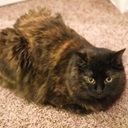

In [5]:
from PIL import Image, ImageOps
from IPython.display import display

cat_image_file = "cat.jpg"

print(f"Loading image: {cat_image_file}...")
cat_image = Image.open(cat_image_file)

display(cat_image)

In [ ]:
# display(ImageOps.invert(cat_image))

In [9]:
pynq_image = Image.open("pynq.jpg")

In [11]:
# example display image
disp = ST7735(               
    rst=True
)
WIDTH = disp.width
HEIGHT = disp.height

# Initialize display.
disp.begin()

# Resize the image
cat_image = cat_image.resize((WIDTH, HEIGHT))
pynq_image = pynq_image.resize((WIDTH, HEIGHT))

for i in range(100):
    # Measure time for displaying cat_image
    start_time = time.time()
    disp.display(cat_image)
    elapsed_time_cat = time.time() - start_time
    print(f"Time to display cat_image: {elapsed_time_cat:.4f} seconds")

    time.sleep(1)

    # Measure time for displaying pynq_image
    start_time = time.time()
    disp.display(pynq_image)
    elapsed_time_pynq = time.time() - start_time
    print(f"Time to display pynq_image: {elapsed_time_pynq:.4f} seconds")

    time.sleep(1)

Time to display cat_image: 0.9833 seconds
Time to display pynq_image: 0.9796 seconds
Time to display cat_image: 0.9857 seconds
Time to display pynq_image: 0.9832 seconds
Time to display cat_image: 0.9849 seconds
Time to display pynq_image: 0.9866 seconds
Time to display cat_image: 0.9836 seconds
Time to display pynq_image: 0.9847 seconds
Time to display cat_image: 0.9867 seconds
Time to display pynq_image: 0.9820 seconds
Time to display cat_image: 0.9839 seconds
Time to display pynq_image: 0.9853 seconds
Time to display cat_image: 0.9831 seconds
Time to display pynq_image: 0.9875 seconds
Time to display cat_image: 0.9875 seconds
Time to display pynq_image: 0.9839 seconds
Time to display cat_image: 0.9874 seconds
Time to display pynq_image: 0.9863 seconds
Time to display cat_image: 0.9841 seconds
Time to display pynq_image: 0.9832 seconds
Time to display cat_image: 0.9877 seconds
Time to display pynq_image: 0.9870 seconds
Time to display cat_image: 0.9858 seconds
Time to display pynq_im

In [130]:
# example draw shape
from PIL import Image, ImageDraw, ImageFont

# Clear the display to a red background.
# Can pass any tuple of red, green, blue values (from 0 to 255 each).
# Get a PIL Draw object to start drawing on the display buffer.
img = Image.new("RGB", (WIDTH, HEIGHT), color=(255, 0, 0))

draw = ImageDraw.Draw(img)

# Draw a purple rectangle with yellow outline.
draw.rectangle((10, 10, WIDTH - 10, HEIGHT - 10), outline=(255, 255, 0), fill=(255, 0, 255))

# Draw some shapes.
# Draw a blue ellipse with a green outline.
draw.ellipse((10, 10, WIDTH - 10, HEIGHT - 10), outline=(0, 255, 0), fill=(0, 0, 255))

# Draw a white X.
draw.line((10, 10, WIDTH - 10, HEIGHT - 10), fill=(255, 255, 255))
draw.line((10, HEIGHT - 10, WIDTH - 10, 10), fill=(255, 255, 255))

# Draw a cyan triangle with a black outline.
draw.polygon([(WIDTH / 2, 10), (WIDTH - 10, HEIGHT - 10), (10, HEIGHT - 10)], outline=(0, 0, 0), fill=(0, 255, 255))

# Load default font.
font = ImageFont.load_default()

# Alternatively load a TTF font.
# Some other nice fonts to try: http://www.dafont.com/bitmap.php
# font = ImageFont.truetype("Minecraftia.ttf", 16)


# Define a function to create rotated text.  Unfortunately PIL doesn"t have good
# native support for rotated fonts, but this function can be used to make a
# text image and rotate it so it"s easy to paste in the buffer.
def draw_rotated_text(image, text, position, angle, font, fill=(255, 255, 255)):
    # Get rendered font width and height.
    width, height = font.getsize(text)
    # Create a new image with transparent background to store the text.
    textimage = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    # Render the text.
    textdraw = ImageDraw.Draw(textimage)
    textdraw.text((0, 0), text, font=font, fill=fill)
    # Rotate the text image.
    rotated = textimage.rotate(angle, expand=1)
    # Paste the text into the image, using it as a mask for transparency.
    image.paste(rotated, position, rotated)


# Write two lines of white text on the buffer, rotated 90 degrees counter clockwise.
draw_rotated_text(img, "Hello World!", (0, 0), 90, font, fill=(255, 255, 255))
draw_rotated_text(img, "This is a line of text.", (10, HEIGHT - 10), 0, font, fill=(255, 255, 255))

# Write buffer to display hardware, must be called to make things visible on the
# display!
disp.display(img)

In [ ]:
# example scrolling text

MESSAGE = "Hello World! How are you today?"


img = Image.new('RGB', (WIDTH, HEIGHT), color=(0, 0, 0))

draw = ImageDraw.Draw(img)

font = ImageFont.truetype("DejaVuSans-Bold.ttf", 30)

size_x, size_y = font.getsize(MESSAGE)

text_x = 160
text_y = (80 - size_y) // 2

t_start = time.time()

while True:
    x = (time.time() - t_start) * 100
    x %= (size_x + 160)
    draw.rectangle((0, 0, 160, 80), (0, 0, 0))
    draw.text((int(text_x - x), text_y), MESSAGE, font=font, fill=(255, 255, 255))
    disp.display(img)